# Проверка гипотез по увеличению выручки в интернет-магазине —оценить результаты A/B теста

<b>Цель:</b>Используя данные интернет-магазина приоритезировать гипотезы, произвести оценку результатов A/B-тестирования различными методами<br>
<b>Описание:</b>проведена приоритизация гипотез по фреймворкам ICE и RICE. Затем провел анализ
результатов A/B-теста, построил графики кумулятивной выручки, среднего чека,
конверсии по группам, а затем посчитал статистическую значимость различий конверсий
и средних чеков по сырым и очищенным данным. На основании анализа мной было
принято решение о нецелесообразности дальнейшего проведения теста.

In [1]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
server_path = 'datasets/'   
local_path = '/datasets/' 

files = ['calls.csv',
         'internet.csv',
         'messages.csv',
         'tariffs.csv',
         'users.csv']

datasets = []

for file in files:
    try:
        datasets.append(pd.read_csv(server_path + file))
    except FileNotFoundError: 
        datasets.append(pd.read_csv(local_path + file))

df_calls = datasets[0]
df_internet = datasets[1]
df_messages = datasets[2]
df_tariffs = datasets[3]
df_users = datasets[4]


## Шаг 2. Подготовьте данные

In [3]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [11]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [12]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Вывод: псоле первичной проверки данных было выявлено: 
- что необходимо привести к типу datatime колонки reg_date, message_date, session_date, call_date
- в колонке df_internet в колонке 'Unnamed: 0' была найдена опечатка

### Приведите данные к нужным типам

Приведем к типу datatime колонки reg_date, message_date, session_date, call_date

In [13]:
def to_dt(df,col):
    df[col] = pd.to_datetime(df[col])

for df, col in [(df_users,   "reg_date"),
                (df_messages,       "message_date"),
                (df_internet,         "session_date"),
                (df_calls,         "call_date")]:
    to_dt(df,col)

In [14]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [15]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [16]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [17]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


### Найдите и исправьте ошибки в данных, если они есть

In [18]:
df_internet.isnull().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

В столбце Unnamed: 0, есть опечатка в виде ":0", уберем ее.

In [19]:
df_internet = df_internet.rename(columns={'Unnamed: 0':'Unnamed'})
df_internet.head()

,Unnamed,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [20]:
df_calls.isnull().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [21]:
df_messages.isnull().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [22]:
df_users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Пропуски в churn_date обоснованы тем, что еще не наступил момент прекращения тарифа. Пропуск означает что пользователь еще использует данный тариф.

### Посчитайте для каждого пользователя:

#### количество сделанных звонков и израсходованных минут разговора по месяцам

In [23]:
df_calls['call_date_m'] = df_calls['call_date'].dt.month
df_calls['duration'] = df_calls['duration'].apply(np.ceil)

In [24]:
df_calls_gr_m = df_calls.groupby(['call_date_m', 'user_id']).agg({'id':'count', 'duration':'sum'}).reset_index()
df_calls_gr_m

,call_date_m,user_id,id,duration
0,1,1005,15,95.0
1,1,1032,61,380.0
2,1,1045,1,9.0
3,1,1055,64,551.0
4,1,1071,24,194.0
...,...,...,...,...
3169,12,1494,62,418.0
3170,12,1495,155,1031.0
3171,12,1496,80,518.0
3172,12,1497,71,545.0


In [25]:
df_calls_gr_m.head(20)

,call_date_m,user_id,id,duration
0,1,1005,15,95.0
1,1,1032,61,380.0
2,1,1045,1,9.0
3,1,1055,64,551.0
4,1,1071,24,194.0
5,1,1113,18,110.0
6,1,1120,5,55.0
7,1,1126,35,272.0
8,1,1134,42,332.0
9,1,1135,9,90.0


#### количество отправленных сообщений по месяцам

In [26]:
df_messages['message_date_m'] = df_messages['message_date'].dt.month

In [27]:
df_messages_gr_m = df_messages.groupby(['message_date_m', 'user_id']).agg({'id':'count'}).reset_index()
df_messages_gr_m

,message_date_m,user_id,id
0,1,1005,7
1,1,1032,38
2,1,1045,5
3,1,1055,30
4,1,1071,16
...,...,...,...
2712,12,1493,78
2713,12,1495,84
2714,12,1496,51
2715,12,1497,17


#### объем израсходованного интернет-трафика по месяцам

In [28]:
df_internet['session_date_m'] = df_internet['session_date'].dt.month

In [29]:
df_internet_gr_m = df_internet.groupby(['session_date_m', 'user_id']).agg({'mb_used':'sum'}).reset_index()
df_internet_gr_m

,session_date_m,user_id,mb_used
0,1,1005,2727.97
1,1,1032,24127.69
2,1,1045,2346.71
3,1,1055,17090.88
4,1,1071,15604.34
...,...,...,...
3198,12,1494,17621.21
3199,12,1495,23426.76
3200,12,1496,20736.15
3201,12,1497,19918.60


In [30]:
df_internet_gr_m['gb_used'] = df_internet_gr_m['mb_used'] / 1024
df_internet_gr_m['gb_used'] = df_internet_gr_m['gb_used'].apply(np.ceil)
df_internet_gr_m.head()

,session_date_m,user_id,mb_used,gb_used
0,1,1005,2727.97,3.0
1,1,1032,24127.69,24.0
2,1,1045,2346.71,3.0
3,1,1055,17090.88,17.0
4,1,1071,15604.34,16.0


#### помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

Сгруппируем данные по пользователю и рассчитаем кол-во и продолжительность звонков звонков

In [31]:
df_calls_gr = df_calls.groupby('user_id').agg({'id':'count', 'duration':'sum'}).reset_index()
df_calls_dr = df_calls_gr.rename(columns={'id':'count_calls'})
df_calls_gr.head()

,user_id,id,duration
0,1000,368,2566.0
1,1001,122,844.0
2,1002,217,1517.0
3,1003,520,3822.0
4,1004,176,987.0


Сгруппируем данные по пользователям и рассчитаем кол-во отправленных сообщений

In [32]:
df_messages_gr = df_messages.groupby('user_id').agg({'id':'count'}).reset_index()
df_messages_gr = df_messages_gr.rename(columns={'id':'count_messages'})
df_messages_gr.head()

,user_id,count_messages
0,1000,496
1,1002,70
2,1003,380
3,1004,1192
4,1005,552


Сгруппируем данные попользователю и рассчитаем  кол-во интернет сессий и кол-во потраченного трафика

In [33]:
df_internet_gr = df_internet.groupby('user_id').agg({'id':'count', 'mb_used':'sum'}).reset_index()
df_internet_gr['gb_used'] = df_internet_gr['mb_used'] / 1024
df_internet_gr['gb_used'] = df_internet_gr['gb_used'].apply(np.ceil)
df_internet_gr = df_internet_gr.rename(columns={'id':'count_internet'})
df_internet_gr.head()

,user_id,count_internet,mb_used,gb_used
0,1000,211,107392.31,105.0
1,1001,96,32466.00,32.0
2,1002,369,116036.52,114.0
3,1003,104,57280.64,56.0
4,1004,300,149039.48,146.0


Соединим таблицу звонков с таблицей сообщений по id пользователя

In [34]:
df_profil_user = df_calls_gr.merge(df_messages_gr, left_on='user_id', right_on='user_id', how='outer')
df_profil_user = df_profil_user.rename(columns={'id':'count_calls'})
df_profil_user.head()

,user_id,count_calls,duration,count_messages
0,1000,368.0,2566.0,496.0
1,1001,122.0,844.0,NaN
2,1002,217.0,1517.0,70.0
3,1003,520.0,3822.0,380.0
4,1004,176.0,987.0,1192.0


Присоединим таблицу интернет трафика

In [35]:
df_profil_user = df_profil_user.merge(df_internet_gr, left_on='user_id', right_on='user_id', how='outer')
df_profil_user.head()

,user_id,count_calls,duration,count_messages,count_internet,mb_used,gb_used
0,1000,368.0,2566.0,496.0,211.0,107392.31,105.0
1,1001,122.0,844.0,NaN,96.0,32466.00,32.0
2,1002,217.0,1517.0,70.0,369.0,116036.52,114.0
3,1003,520.0,3822.0,380.0,104.0,57280.64,56.0
4,1004,176.0,987.0,1192.0,300.0,149039.48,146.0


Добавим столбец с тарифом в итоговую таблицу

In [36]:
df_profil_user = df_profil_user.merge(df_users[['user_id', 'city', 'tariff']], left_on='user_id', right_on='user_id', how='outer')
df_profil_user.head()

,user_id,count_calls,duration,count_messages,count_internet,mb_used,gb_used,city,tariff
0,1000,368.0,2566.0,496.0,211.0,107392.31,105.0,Краснодар,ultra
1,1001,122.0,844.0,NaN,96.0,32466.00,32.0,Москва,smart
2,1002,217.0,1517.0,70.0,369.0,116036.52,114.0,Стерлитамак,smart
3,1003,520.0,3822.0,380.0,104.0,57280.64,56.0,Москва,ultra
4,1004,176.0,987.0,1192.0,300.0,149039.48,146.0,Новокузнецк,ultra


Вычтим входящие в тариф минуты из потраченных. Если минут затрачено меньше, чем в ходит тариф, то заменим значение на 0

In [37]:
def duration(row):
    if row['tariff'] == 'smart':
        if row['duration'] > 500:
            return row['duration'] - 500
        else:
            return 0
    if row['tariff'] == 'ultra':
        if row['duration'] > 3000:
            return row['duration'] - 3000
        else:
            return 0
df_profil_user['duration_clear'] = df_profil_user.apply(duration, axis=1)
df_profil_user.head()

,user_id,count_calls,duration,count_messages,count_internet,mb_used,gb_used,city,tariff,duration_clear
0,1000,368.0,2566.0,496.0,211.0,107392.31,105.0,Краснодар,ultra,0.0
1,1001,122.0,844.0,NaN,96.0,32466.00,32.0,Москва,smart,344.0
2,1002,217.0,1517.0,70.0,369.0,116036.52,114.0,Стерлитамак,smart,1017.0
3,1003,520.0,3822.0,380.0,104.0,57280.64,56.0,Москва,ultra,822.0
4,1004,176.0,987.0,1192.0,300.0,149039.48,146.0,Новокузнецк,ultra,0.0


Вычтим входящие в тариф кол-во сообщений. Если сообщений меньше, то вернем 0

In [38]:
def count_messages(row):
    if row['tariff'] == 'smart':
        if row['count_messages'] > 50:
            return row['count_messages'] - 50
        else:
            return 0
    if row['tariff'] == 'ultra':
        if row['count_messages'] > 1000:
            return row['count_messages'] - 1000
        else:
            return 0
df_profil_user['count_messages_clear'] = df_profil_user.apply(count_messages, axis=1)
df_profil_user.head()

,user_id,count_calls,duration,count_messages,count_internet,mb_used,gb_used,city,tariff,duration_clear,count_messages_clear
0,1000,368.0,2566.0,496.0,211.0,107392.31,105.0,Краснодар,ultra,0.0,0.0
1,1001,122.0,844.0,NaN,96.0,32466.00,32.0,Москва,smart,344.0,0.0
2,1002,217.0,1517.0,70.0,369.0,116036.52,114.0,Стерлитамак,smart,1017.0,20.0
3,1003,520.0,3822.0,380.0,104.0,57280.64,56.0,Москва,ultra,822.0,0.0
4,1004,176.0,987.0,1192.0,300.0,149039.48,146.0,Новокузнецк,ultra,0.0,192.0


Вычтим трафик интернета входящий в тариф.

In [39]:
def count_internet(row):
    if row['tariff'] == 'smart':
        if row['gb_used'] > 15:
            return row['gb_used'] - 15
        else:
            return 0
    if row['tariff'] == 'ultra':
        if row['gb_used'] > 30:
            return row['gb_used'] - 30
        else:
            return 0
df_profil_user['gb_used_clear'] = df_profil_user.apply(count_internet, axis=1)
df_profil_user.head()

,user_id,count_calls,duration,count_messages,count_internet,mb_used,gb_used,city,tariff,duration_clear,count_messages_clear,gb_used_clear
0,1000,368.0,2566.0,496.0,211.0,107392.31,105.0,Краснодар,ultra,0.0,0.0,75.0
1,1001,122.0,844.0,NaN,96.0,32466.00,32.0,Москва,smart,344.0,0.0,17.0
2,1002,217.0,1517.0,70.0,369.0,116036.52,114.0,Стерлитамак,smart,1017.0,20.0,99.0
3,1003,520.0,3822.0,380.0,104.0,57280.64,56.0,Москва,ultra,822.0,0.0,26.0
4,1004,176.0,987.0,1192.0,300.0,149039.48,146.0,Новокузнецк,ultra,0.0,192.0,116.0


Расчитаем выручку с каждого пользователя

In [40]:
def income(row):
    if row['tariff'] == 'smart':
        return row['duration_clear'] * 3 + row['count_messages_clear'] * 3 + row['gb_used_clear'] * 200 + 550
    if row['tariff'] == 'ultra':
        return row['duration_clear'] * 1 + row['count_messages_clear'] * 1 + row['gb_used_clear'] * 150 + 1950
df_profil_user['income'] = df_profil_user.apply(income, axis=1)
df_profil_user.head()

,user_id,count_calls,duration,count_messages,count_internet,mb_used,gb_used,city,tariff,duration_clear,count_messages_clear,gb_used_clear,income
0,1000,368.0,2566.0,496.0,211.0,107392.31,105.0,Краснодар,ultra,0.0,0.0,75.0,13200.0
1,1001,122.0,844.0,NaN,96.0,32466.00,32.0,Москва,smart,344.0,0.0,17.0,4982.0
2,1002,217.0,1517.0,70.0,369.0,116036.52,114.0,Стерлитамак,smart,1017.0,20.0,99.0,23461.0
3,1003,520.0,3822.0,380.0,104.0,57280.64,56.0,Москва,ultra,822.0,0.0,26.0,6672.0
4,1004,176.0,987.0,1192.0,300.0,149039.48,146.0,Новокузнецк,ultra,0.0,192.0,116.0,19542.0


## Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Разделим данные на две группы пользователей smart и ultra

In [41]:
df_calls_gr_m_tariff = df_calls_gr_m.merge(df_users[['user_id', 'city', 'tariff']], left_on='user_id', right_on='user_id', how='outer')
df_calls_gr_m_tariff.head()

,call_date_m,user_id,id,duration,city,tariff
0,1.0,1005,15.0,95.0,Набережные Челны,smart
1,2.0,1005,69.0,456.0,Набережные Челны,smart
2,3.0,1005,77.0,606.0,Набережные Челны,smart
3,4.0,1005,101.0,712.0,Набережные Челны,smart
4,5.0,1005,73.0,595.0,Набережные Челны,smart


In [42]:
df_messages_gr_m_tariff = df_messages_gr_m.merge(df_users[['user_id', 'city', 'tariff']], left_on='user_id', right_on='user_id', how='outer')
df_messages_gr_m_tariff.head()

,message_date_m,user_id,id,city,tariff
0,1.0,1005,7.0,Набережные Челны,smart
1,2.0,1005,38.0,Набережные Челны,smart
2,3.0,1005,56.0,Набережные Челны,smart
3,4.0,1005,41.0,Набережные Челны,smart
4,5.0,1005,42.0,Набережные Челны,smart


In [43]:
df_internet_gr_m_tariff = df_internet_gr_m.merge(df_users[['user_id', 'city', 'tariff']], left_on='user_id', right_on='user_id', how='outer')
df_internet_gr_m_tariff.head()

,session_date_m,user_id,mb_used,gb_used,city,tariff
0,1.0,1005,2727.97,3.0,Набережные Челны,smart
1,2.0,1005,7383.93,8.0,Набережные Челны,smart
2,3.0,1005,11104.25,11.0,Набережные Челны,smart
3,4.0,1005,9351.72,10.0,Набережные Челны,smart
4,5.0,1005,7865.53,8.0,Набережные Челны,smart


In [44]:
df_calls_gr_m_tariff_smart = df_calls_gr_m_tariff[df_calls_gr_m_tariff['tariff'] == 'smart']
df_messages_gr_m_tariff_smart = df_messages_gr_m_tariff[df_messages_gr_m_tariff['tariff'] == 'smart']
df_internet_gr_m_tariff_smart = df_internet_gr_m_tariff[df_internet_gr_m_tariff['tariff'] == 'smart']

In [45]:
df_calls_gr_m_tariff_ultra = df_calls_gr_m_tariff[df_calls_gr_m_tariff['tariff'] == 'ultra']
df_messages_gr_m_tariff_ultra = df_messages_gr_m_tariff[df_messages_gr_m_tariff['tariff'] == 'ultra']
df_internet_gr_m_tariff_ultra = df_internet_gr_m_tariff[df_internet_gr_m_tariff['tariff'] == 'ultra']

#### Пользователи smart

In [46]:
df_calls_gr_m_tariff_smart.groupby('call_date_m').agg({'duration':'mean'})

,duration
call_date_m,
1.0,203.852941
2.0,298.689655
3.0,390.051948
4.0,367.133929
5.0,387.361702
6.0,398.067485
7.0,408.353234
8.0,423.269231
9.0,430.266409


In [47]:
print('Среднее в месяц:', df_calls_gr_m_tariff_smart.groupby('call_date_m').agg({'duration':'mean'}).reset_index()['duration'].mean())

Среднее в месяц: 387.605809617519


array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

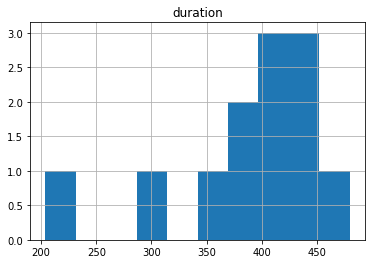

In [48]:
df_calls_gr_m_tariff_smart.groupby('call_date_m').agg({'duration':'mean'}).hist()

видно что пользователи начинают тратить больше минут на разговоры к концу года. Так же видно сильное проседание в начале года.

In [49]:
df_calls_gr_m_tariff_smart.groupby('call_date_m')['duration'].var()

call_date_m
1.0     23787.341355
2.0     36412.287961
3.0     36823.155161
4.0     34778.207127
5.0     34820.061094
6.0     29960.520109
7.0     32250.269602
8.0     34177.270551
9.0     32950.529526
10.0    34889.530319
11.0    31100.611101
12.0    39131.447539
Name: duration, dtype: float64

In [50]:
df_calls_gr_m_tariff_smart.groupby('call_date_m')['duration'].std()

call_date_m
1.0     154.231454
2.0     190.820041
3.0     191.893604
4.0     186.489161
5.0     186.601343
6.0     173.091075
7.0     179.583601
8.0     184.870956
9.0     181.522807
10.0    186.787393
11.0    176.353653
12.0    197.816702
Name: duration, dtype: float64

Из полученных данных видно, что меньше всего пользователи разговаривают в первые два месяца. К концу года активность резко возрастает.

In [51]:
df_messages_gr_m_tariff_smart.groupby('message_date_m')['id'].mean()

message_date_m
1.0     20.000000
2.0     27.940000
3.0     35.550725
4.0     35.864583
5.0     39.032787
6.0     38.577465
7.0     38.988506
8.0     38.750000
9.0     39.219731
10.0    39.082677
11.0    39.881481
12.0    42.264808
Name: id, dtype: float64

In [52]:
print('Среднее в месяц:', df_messages_gr_m_tariff_smart.groupby('message_date_m')['id'].mean().reset_index()['id'].mean())

Среднее в месяц: 36.2627302785857


<AxesSubplot:>

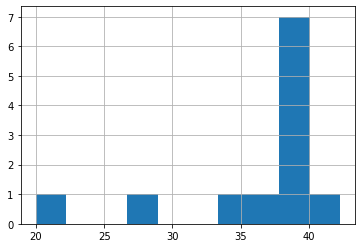

In [53]:
df_messages_gr_m_tariff_smart.groupby('message_date_m')['id'].mean().hist()

Можно заметить на графике склонность к нормальному распределению. Выбрасы слевой стороны обоснованы первыми месяцами года. Данная ситуация наблюдается и далее. Так же стоит заметить что большая часть пользователей тратит схожее кол-во сообщений.

In [54]:
df_messages_gr_m_tariff_smart.groupby('message_date_m')['id'].var()

message_date_m
1.0     252.133333
2.0     440.465714
3.0     669.780477
4.0     517.865680
5.0     638.775776
6.0     731.635801
7.0     719.352468
8.0     767.213054
9.0     702.505555
10.0    736.503019
11.0    711.361366
12.0    832.447114
Name: id, dtype: float64

In [55]:
df_messages_gr_m_tariff_smart.groupby('message_date_m')['id'].std()

message_date_m
1.0     15.878707
2.0     20.987275
3.0     25.880117
4.0     22.756662
5.0     25.274014
6.0     27.048767
7.0     26.820747
8.0     27.698611
9.0     26.504821
10.0    27.138589
11.0    26.671359
12.0    28.852160
Name: id, dtype: float64

С отправкой сообщений ситуация похожа с разговорами по телефону. Резкий рост отправки сообщений виден к концу года.

In [56]:
df_internet_gr_m_tariff_smart.groupby('session_date_m')['gb_used'].mean()

session_date_m
1.0      8.735294
2.0     11.844828
3.0     15.233766
4.0     13.625000
5.0     15.907801
6.0     15.951220
7.0     15.875622
8.0     16.807692
9.0     16.392308
10.0    16.880952
11.0    17.000000
12.0    18.201780
Name: gb_used, dtype: float64

In [57]:
print('Среднее в месяц:', df_internet_gr_m_tariff_smart.groupby('session_date_m')['gb_used'].mean().reset_index()['gb_used'].mean())

Среднее в месяц: 15.204688629598747


<AxesSubplot:>

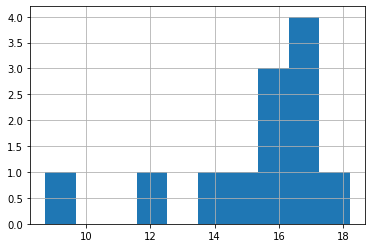

In [58]:
df_internet_gr_m_tariff_smart.groupby('session_date_m')['gb_used'].mean().hist()

График показывает нормально распределение, видны выбрасы слевой стороны по первым двум месяцам года. Так же видно, что пользователи тратят стабильно 15-16гб, к концу года кол-во израсход. трафика увеличивается 

In [59]:
df_internet_gr_m_tariff_smart.groupby('session_date_m')['gb_used'].var()

session_date_m
1.0     39.412656
2.0     37.150938
3.0     32.549897
4.0     31.299550
5.0     34.370010
6.0     31.911716
7.0     33.419453
8.0     28.962859
9.0     25.884110
10.0    32.897042
11.0    27.180952
12.0    29.786544
Name: gb_used, dtype: float64

In [60]:
df_internet_gr_m_tariff_smart.groupby('session_date_m')['gb_used'].std()

session_date_m
1.0     6.277950
2.0     6.095157
3.0     5.705252
4.0     5.594600
5.0     5.862594
6.0     5.649046
7.0     5.780956
8.0     5.381715
9.0     5.087643
10.0    5.735594
11.0    5.213535
12.0    5.457705
Name: gb_used, dtype: float64

Потребление интернет трафика заничительно меньше в начале года. К концу года наблюдается рост.

Вывод по пользователям тарифа smart: как видно из полученных данных в январе - феврале пользователи меньше всего активны, скорее всего это связано с новогодними каникулами. К концу года наблюдается рост. Рост связан скорее всего с приближением нового года, поздравления, поиски подарков и т.д. 

#### Пользователи ultra

In [61]:
df_calls_gr_m_tariff_ultra.groupby('call_date_m').agg({'duration':'mean'})

,duration
call_date_m,
1.0,428.111111
2.0,297.125000
3.0,489.648649
4.0,475.301887
5.0,534.250000
6.0,497.469136
7.0,564.397727
8.0,530.611650
9.0,558.882883


In [62]:
print('Среднее в месяц:', df_calls_gr_m_tariff_ultra.groupby('call_date_m').agg({'duration':'mean'}).reset_index()['duration'].mean())

Среднее в месяц: 511.23471423122083


array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

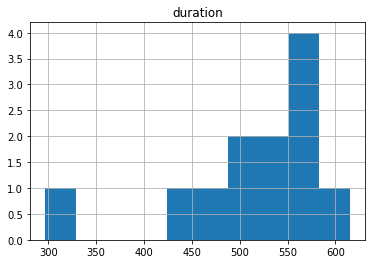

In [63]:
df_calls_gr_m_tariff_ultra.groupby('call_date_m').agg({'duration':'mean'}).hist()

Из данных видно, что у пользователей тарифа ultra расход минут более стабилен, проседание видно только в феврале. Так же отмечается рост к концу года

In [64]:
df_calls_gr_m_tariff_ultra.groupby('call_date_m')['duration'].var()

call_date_m
1.0      72769.361111
2.0      87919.679348
3.0     111384.900901
4.0      66036.830189
5.0      74881.015873
6.0      86019.652160
7.0      86952.587121
8.0      91169.553588
9.0      98597.904341
10.0     97140.336086
11.0     88449.624031
12.0    107981.031983
Name: duration, dtype: float64

In [65]:
df_calls_gr_m_tariff_ultra.groupby('call_date_m')['duration'].std()

call_date_m
1.0     269.757968
2.0     296.512528
3.0     333.743765
4.0     256.976322
5.0     273.643958
6.0     293.291071
7.0     294.877241
8.0     301.942964
9.0     314.003032
10.0    311.673445
11.0    297.404815
12.0    328.604674
Name: duration, dtype: float64

При этом разброс значений больше, чем у пользователей smart

In [66]:
df_messages_gr_m_tariff_ultra.groupby('message_date_m')['id'].mean()

message_date_m
1.0     43.428571
2.0     32.937500
3.0     47.800000
4.0     44.512821
5.0     48.769231
6.0     52.313433
7.0     62.136986
8.0     58.897727
9.0     63.294737
10.0    69.776699
11.0    66.159292
12.0    72.008547
Name: id, dtype: float64

In [67]:
print('Среднее в месяц:', df_messages_gr_m_tariff_ultra.groupby('message_date_m')['id'].mean().reset_index()['id'].mean())

Среднее в месяц: 55.169628669643124


<AxesSubplot:>

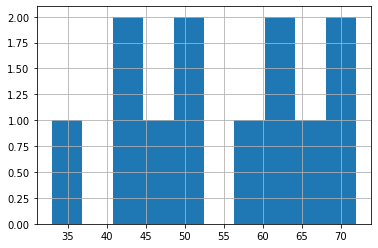

In [68]:
df_messages_gr_m_tariff_ultra.groupby('message_date_m')['id'].mean().hist()

В значениях для пользователей ultra наблюдается отсутвие нормального распределения данных

In [69]:
df_messages_gr_m_tariff_ultra.groupby('message_date_m')['id'].var()

message_date_m
1.0      765.285714
2.0      713.395833
3.0     1826.666667
4.0     1408.256410
5.0     1559.553544
6.0     1935.672999
7.0     2190.730974
8.0     2022.966432
9.0     1906.763270
10.0    2426.606511
11.0    2249.295828
12.0    2362.870616
Name: id, dtype: float64

In [70]:
df_messages_gr_m_tariff_ultra.groupby('message_date_m')['id'].std()

message_date_m
1.0     27.663798
2.0     26.709471
3.0     42.739521
4.0     37.526743
5.0     39.491183
6.0     43.996284
7.0     46.805245
8.0     44.977399
9.0     43.666501
10.0    49.260598
11.0    47.426742
12.0    48.609368
Name: id, dtype: float64

Можно заметить, что разброс увеличивается начиная с марта и до конца года

In [71]:
df_internet_gr_m_tariff_ultra.groupby('session_date_m')['gb_used'].mean()

session_date_m
1.0     13.222222
2.0     13.090909
3.0     17.648649
4.0     16.963636
5.0     19.666667
6.0     19.168675
7.0     20.733333
8.0     19.783019
9.0     19.412281
10.0    20.229508
11.0    19.954887
12.0    21.898551
Name: gb_used, dtype: float64

In [72]:
print('Среднее в месяц:', df_internet_gr_m_tariff_ultra.groupby('session_date_m')['gb_used'].mean().reset_index()['gb_used'].mean())

Среднее в месяц: 18.481028061107875


<AxesSubplot:>

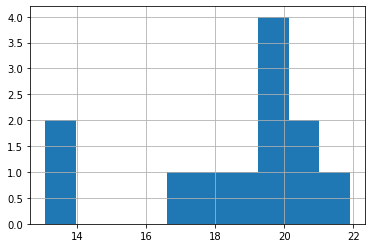

In [73]:
df_internet_gr_m_tariff_ultra.groupby('session_date_m')['gb_used'].mean().hist()

Из данных видно, что расход интернет трафика так же резко проседает в первые месяцы. Далее заметно нормальное распределение данных. Так же видно, что пользователи начиная с мая трят стабильно 19-20гб, есть небольшой рост в декабре

In [74]:
df_internet_gr_m_tariff_ultra.groupby('session_date_m')['gb_used'].var()

session_date_m
1.0      44.444444
2.0     104.562771
3.0     114.345345
4.0      89.443098
5.0      91.241026
6.0      78.971202
7.0      92.737079
8.0     102.457233
9.0      83.713476
10.0     88.657634
11.0     91.513101
12.0    100.515180
Name: gb_used, dtype: float64

In [75]:
df_internet_gr_m_tariff_ultra.groupby('session_date_m')['gb_used'].std()

session_date_m
1.0      6.666667
2.0     10.225594
3.0     10.693238
4.0      9.457436
5.0      9.552017
6.0      8.886574
7.0      9.630009
8.0     10.122116
9.0      9.149507
10.0     9.415818
11.0     9.566248
12.0    10.025726
Name: gb_used, dtype: float64

Сравнение данных по двум тарифам

Вывод по пользователям ultra: виден сильный разброс в данных по расходу сообщений. Как и пользователей smart первые два месяца хуже остальных и виден рост к концу года

Общий вывод по разделу: если проанализировать стартовые два пакета и как их расходуют пользователи, то видно что по звонкам и сообщениям пользователи чаще всего укладываются в пакеты. По интернет трафику не укладываются пользователи   smart, превышение не больше 15%. Стоит отметить, что пользователи ultra сильно не добирают по расходу пакета услуг, особенно по интернет трафику и сообщениям.

## Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. <br>
Пороговое значение alpha задайте самостоятельно. <br>
Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

Для рассчета будем использовать метод scipy.stats.ttest_ind (Гипотеза о равенстве средних двух генеральных совокупностей)

За H0 будем брать гипотезу о равенстве двух выборок, за H1 противоположную гипотезу

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

Сохраним нужные данные по выручки двух категорий клиентов

In [76]:
df_profil_user

,user_id,count_calls,duration,count_messages,count_internet,mb_used,gb_used,city,tariff,duration_clear,count_messages_clear,gb_used_clear,income
0,1000,368.0,2566.0,496.0,211.0,107392.31,105.0,Краснодар,ultra,0.0,0.0,75.0,13200.0
1,1001,122.0,844.0,NaN,96.0,32466.00,32.0,Москва,smart,344.0,0.0,17.0,4982.0
2,1002,217.0,1517.0,70.0,369.0,116036.52,114.0,Стерлитамак,smart,1017.0,20.0,99.0,23461.0
3,1003,520.0,3822.0,380.0,104.0,57280.64,56.0,Москва,ultra,822.0,0.0,26.0,6672.0
4,1004,176.0,987.0,1192.0,300.0,149039.48,146.0,Новокузнецк,ultra,0.0,192.0,116.0,19542.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1328,NaN,NaN,21.0,208.0,97373.29,96.0,Мурманск,ultra,0.0,0.0,66.0,11850.0
496,1473,NaN,NaN,90.0,163.0,83975.96,83.0,Красноярск,ultra,0.0,0.0,53.0,9900.0
497,1489,NaN,NaN,125.0,266.0,82630.37,81.0,Санкт-Петербург,smart,0.0,75.0,66.0,13975.0
498,1128,NaN,NaN,NaN,NaN,NaN,NaN,Волжский,ultra,0.0,0.0,0.0,1950.0


In [77]:
df_profil_user_ultra = df_profil_user[df_profil_user['tariff'] == 'ultra'][['income']].sample(n=100)
df_profil_user_smart = df_profil_user[df_profil_user['tariff'] == 'smart'][['income']].sample(n=100)

In [78]:
df_profil_user_ultra.head()

,income
163,4800.0
222,24737.0
336,30433.0
193,31310.0
78,24424.0


In [79]:
df_profil_user_smart.head()

,income
276,25572.0
443,23117.0
329,4756.0
194,35014.0
184,17742.0


array([[<AxesSubplot:title={'center':'income'}>]], dtype=object)

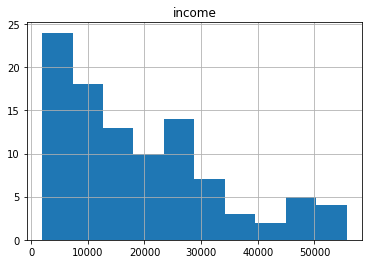

In [80]:
df_profil_user_ultra.hist()

array([[<AxesSubplot:title={'center':'income'}>]], dtype=object)

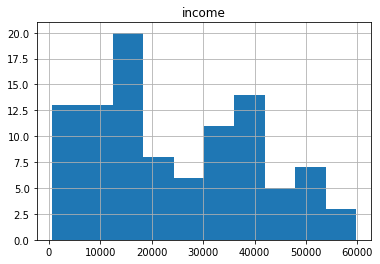

In [81]:
df_profil_user_smart.hist()

Сформулируем две гипотезы: <br>
H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны. <br>
H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различны.

In [82]:
alpha = .05 # пороговое значение возьмем за 5%

results = st.ttest_ind(
    df_profil_user_smart, 
    df_profil_user_ultra)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [0.00516481]
Отвергаем нулевую гипотезу


Из полученных данных можем предположить, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различна.

#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

Сохраним нужные данные:

In [83]:
df_profil_user['city'] = df_profil_user['city'].str.lower()
df_profil_user_moskow = df_profil_user[df_profil_user['city'] == 'москва'][['income']].sample(n=70)
df_profil_user_unmoskow = df_profil_user[df_profil_user['city'] != 'москва'][['income']].sample(n=70)

array([[<AxesSubplot:title={'center':'income'}>]], dtype=object)

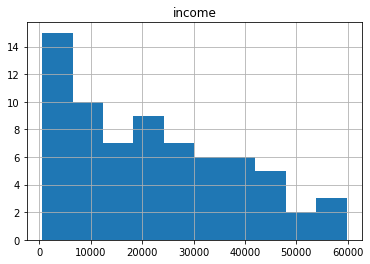

In [84]:
df_profil_user_moskow.hist()

array([[<AxesSubplot:title={'center':'income'}>]], dtype=object)

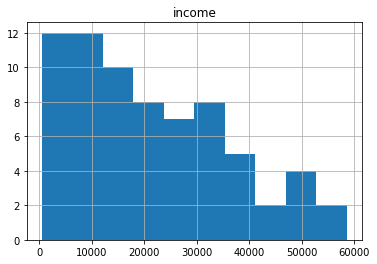

In [85]:
df_profil_user_unmoskow.hist()

H0:средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов <br>
H1:средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [86]:
alpha = .05 # пороговое значение возьмем за 5%

results = st.ttest_ind(
    df_profil_user_moskow, 
    df_profil_user_unmoskow)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: [0.77564625]
Не получилось отвергнуть нулевую гипотезу


Из полученных данный можно предположить, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

## Шаг 5. Напишите общий вывод

Вывод: из исследования можно сделать выводы:
- пользователи smart чаще всего расходуют больше мбайт, чем входит в пакет
- пользователи ultra чаще всего расходуют в пределах 65 %  от входящего в тариф пакета (и это трафик интернета). если мы проанализируем звонки и сообщения, то там показатели меньше 20%.
- стоит отметить что пользователи smart превышают пакет интренета не больше 2ГБ (с учетом окрубления в большую сторону), что приносит в районе 400р. Если сравнивать абоненскую плату + превышения лимита, то пользователи тарифа ultra выгоднее для поставщика услуг т.к. абоненская плата по тарифу больше тарифа smart + превышения в 2Гб. Так же пользователи тарифа ultra платят за пакеты, которые не могут израсходовать и пакеты остаются полнымив большей степени к концу месяца.
- средняя выручка не отличается в зависимости от региона
Если подвести итог, то могу заметить, что для поставщика услуг пользователи тарифа smart являются более выгодными т.к.:
- они не расходуют очень сильно свои вкл в стоимость абонента пакеты
- переплаты за перерасход пользователей smart значительно меньше, чем абоненская плата пользователей ultra.